# MovieLens 1M - Exploratory Data Analysis (EDA)

This notebook covers the initial exploration of the MovieLens 1M dataset. We will load the data, check for data quality issues, and visualize key distributions (ratings, genres, user activity) to understand the dataset before modeling.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Set style for plots
sns.set_style("whitegrid")
%matplotlib inline

## 1. Load Data

MovieLens 1M files are `.dat` files with `::` as separator. We need to specify the encoding as `latin-1` or `ISO-8859-1`.

In [15]:
# Define file paths
MOVIES_FILE = "../data/ml-1m/movies.dat"
RATINGS_FILE = "../data/ml-1m/ratings.dat"
USERS_FILE = "../data/ml-1m/users.dat"

# Define column names (based on README/documentation)
movies_cols = ['MovieID', 'Title', 'Genres']
ratings_cols = ['UserID', 'MovieID', 'Rating', 'Timestamp']
users_cols = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']

# Load data
print("Loading movies...")
movies = pd.read_csv(MOVIES_FILE, sep='::', header=None, names=movies_cols, engine='python', encoding='latin-1')

print("Loading ratings...")
ratings = pd.read_csv(RATINGS_FILE, sep='::', header=None, names=ratings_cols, engine='python', encoding='latin-1')

print("Loading users...")
users = pd.read_csv(USERS_FILE, sep='::', header=None, names=users_cols, engine='python', encoding='latin-1')

print("Data loaded successfully!")

Loading movies...
Loading ratings...
Loading users...
Data loaded successfully!


In [16]:
# Check dimensions
print(f"Movies shape: {movies.shape}")
print(f"Ratings shape: {ratings.shape}")
print(f"Users shape: {users.shape}")

Movies shape: (3883, 3)
Ratings shape: (1000209, 4)
Users shape: (6040, 5)


In [17]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [18]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 2. Basic Analysis & Data Quality
Check for missing values and duplicates.

In [19]:
print("Missing values in Movies:")
print(movies.isnull().sum())
print("\nMissing values in Ratings:")
print(ratings.isnull().sum())

Missing values in Movies:
MovieID    0
Title      0
Genres     0
dtype: int64

Missing values in Ratings:
UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64


## 3. Visualizations

### 3.1 Rating Distribution
What are the most common ratings? Are users generous or critical?

/tmp/ipykernel_21309/4277498499.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=ratings, palette='viridis')


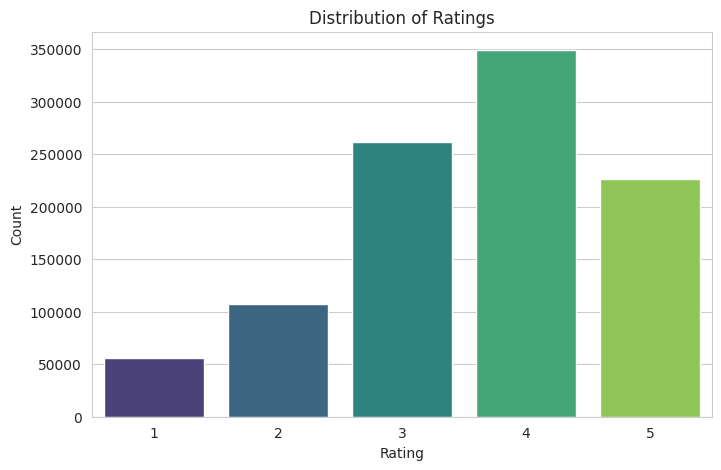

In [20]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Rating', data=ratings, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

### 3.2 Most Rated Movies
Which movies have the highest number of ratings (Popularity)?

Top 10 Most Rated Movies:
Title
American Beauty (1999)                                   3428
Star Wars: Episode IV - A New Hope (1977)                2991
Star Wars: Episode V - The Empire Strikes Back (1980)    2990
Star Wars: Episode VI - Return of the Jedi (1983)        2883
Jurassic Park (1993)                                     2672
Saving Private Ryan (1998)                               2653
Terminator 2: Judgment Day (1991)                        2649
Matrix, The (1999)                                       2590
Back to the Future (1985)                                2583
Silence of the Lambs, The (1991)                         2578
dtype: int64


/tmp/ipykernel_21309/1278385640.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=rating_counts.head(20).index, x=rating_counts.head(20).values, palette='magma')


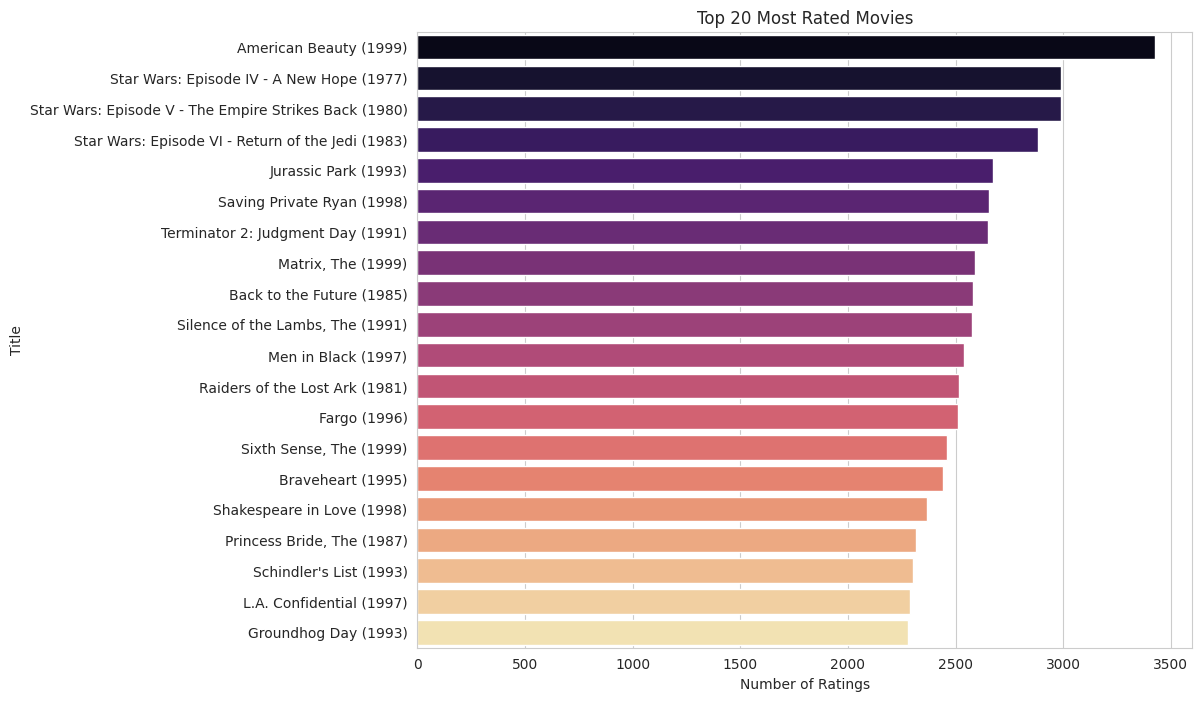

In [21]:
# Merge ratings with movie titles
movie_ratings = ratings.merge(movies, on='MovieID')

# Count ratings per movie
rating_counts = movie_ratings.groupby('Title').size().sort_values(ascending=False)

print("Top 10 Most Rated Movies:")
print(rating_counts.head(10))

# Plot top 20
plt.figure(figsize=(10, 8))
sns.barplot(y=rating_counts.head(20).index, x=rating_counts.head(20).values, palette='magma')
plt.title('Top 20 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.show()

### 3.3 Top Rated Movies (with Minimum Interactions)
High ratings are only meaningful if there is a sufficient number of votes. Let's find the best movies among those that have at least 100 ratings.

Top 10 Highest Rated Movies (with > 100 ratings):
                                                  Title  count      mean
1839  Seven Samurai (The Magnificent Seven) (Shichin...    628  4.560510
309                    Shawshank Redemption, The (1994)   2227  4.554558
802                               Godfather, The (1972)   2223  4.524966
708                               Close Shave, A (1995)    657  4.520548
49                           Usual Suspects, The (1995)   1783  4.517106
513                             Schindler's List (1993)   2304  4.510417
1066                         Wrong Trousers, The (1993)    882  4.507937
861       Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)    470  4.491489
1108                     Raiders of the Lost Ark (1981)   2514  4.477725
843                                  Rear Window (1954)   1050  4.476190


/tmp/ipykernel_21309/62579785.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mean', y='Title', data=top_rated.head(10), palette='RdYlGn')


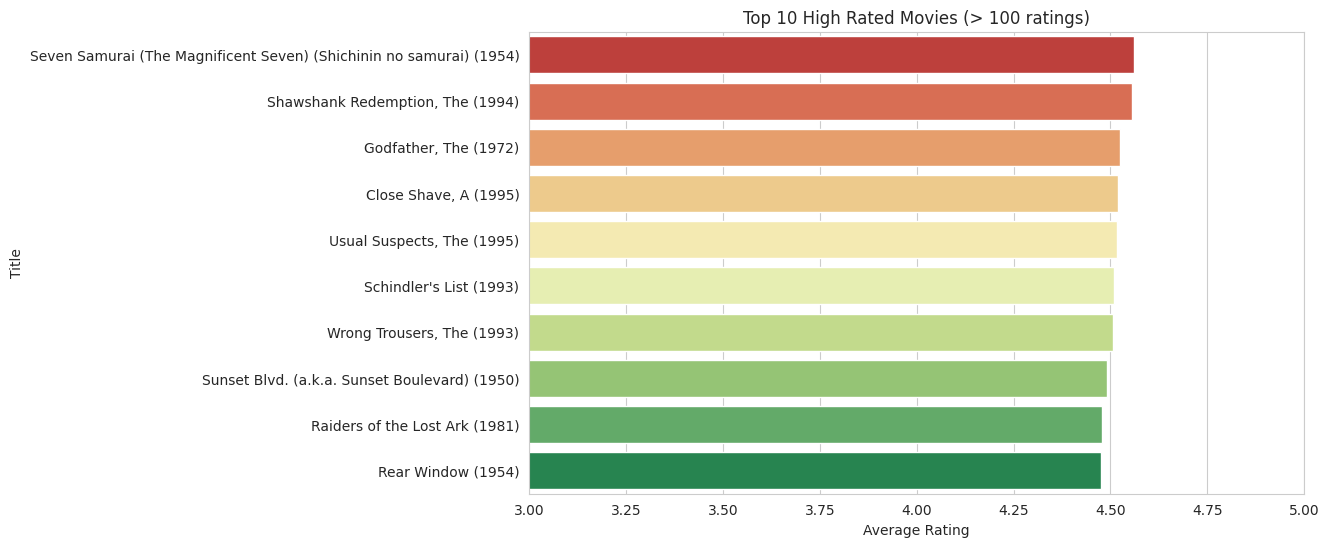

In [22]:
# Calculate count and mean rating per movie
movie_stats = ratings.groupby('MovieID')['Rating'].agg(['count', 'mean'])
movie_stats = movie_stats.merge(movies, on='MovieID')

# Filter: at least 100 ratings
min_votes = 100
popular_movies = movie_stats[movie_stats['count'] >= min_votes]

# Sort by mean rating
top_rated = popular_movies.sort_values('mean', ascending=False)

print(f"Top 10 Highest Rated Movies (with > {min_votes} ratings):")
print(top_rated[['Title', 'count', 'mean']].head(10))

# Plot top 10
plt.figure(figsize=(10, 6))
sns.barplot(x='mean', y='Title', data=top_rated.head(10), palette='RdYlGn')
plt.title(f'Top 10 High Rated Movies (> {min_votes} ratings)')
plt.xlabel('Average Rating')
plt.xlim(3, 5) # Focus on the scale 3-5
plt.show()

### 3.4 User Activity
How many ratings does the average user give? This helps identify the "Long Tail".

Max ratings by one user: 2314
Min ratings by one user: 20
Average ratings per user: 165.60


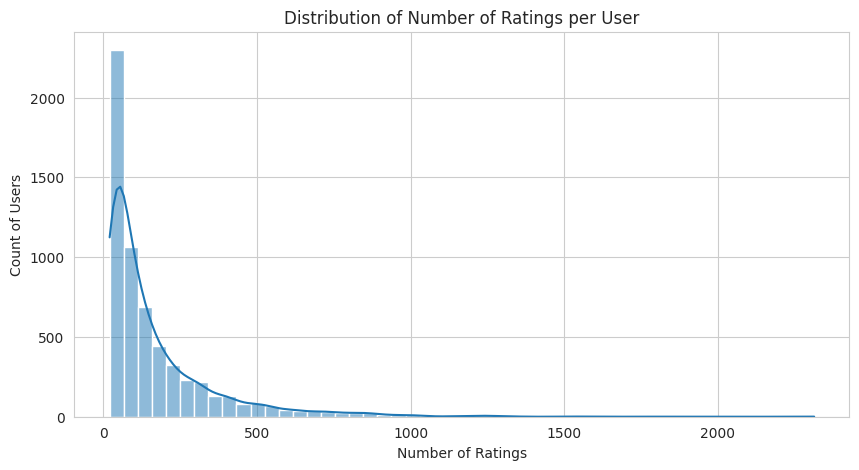

In [23]:
user_counts = ratings.groupby('UserID').size()

print(f"Max ratings by one user: {user_counts.max()}")
print(f"Min ratings by one user: {user_counts.min()}")
print(f"Average ratings per user: {user_counts.mean():.2f}")

plt.figure(figsize=(10, 5))
sns.histplot(user_counts, bins=50, kde=True)
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.show()

### 3.5 Genres Analysis (Validation for Content-Based Filtering)

Since we decided to use TF-IDF for genres, it is crucial to understand the genre space better.
1.  **Genre Distribution**: Which genres are common vs rare (rare genres have higher IDF weight).
2.  **Genre Co-occurrence**: Which genres tend to appear together?
3.  **TF-IDF Sanity Check**: Can we find similar movies purely based on genres?

/tmp/ipykernel_21309/3842090303.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='coolwarm')


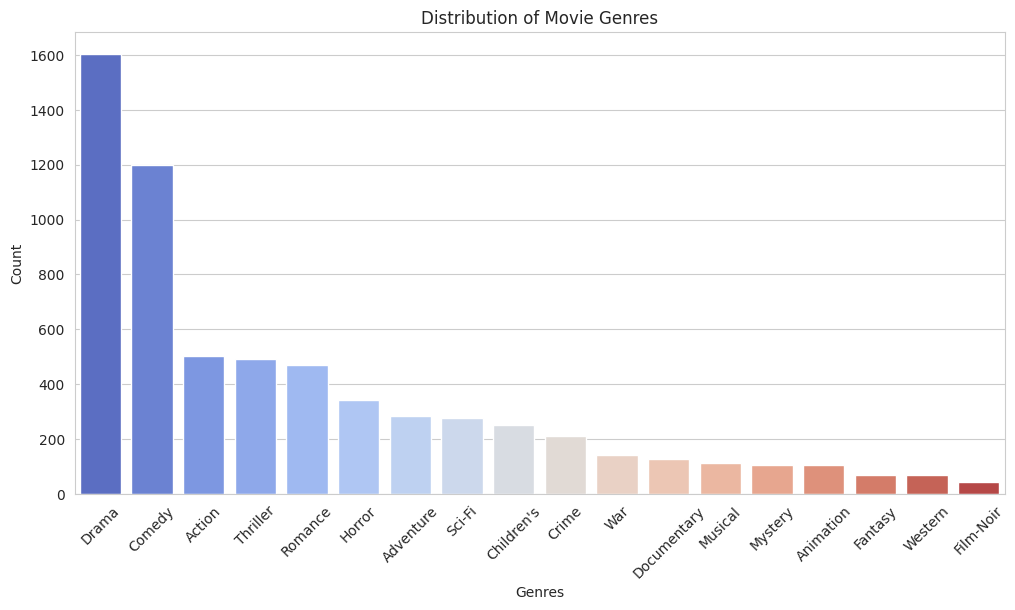

In [24]:
# 1. Basic Counts
genres_df = movies.copy()
genres_df['Genres'] = genres_df['Genres'].str.split('|')
genres_exploded = genres_df.explode('Genres')

genre_counts = genres_exploded['Genres'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='coolwarm')
plt.title('Distribution of Movie Genres')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

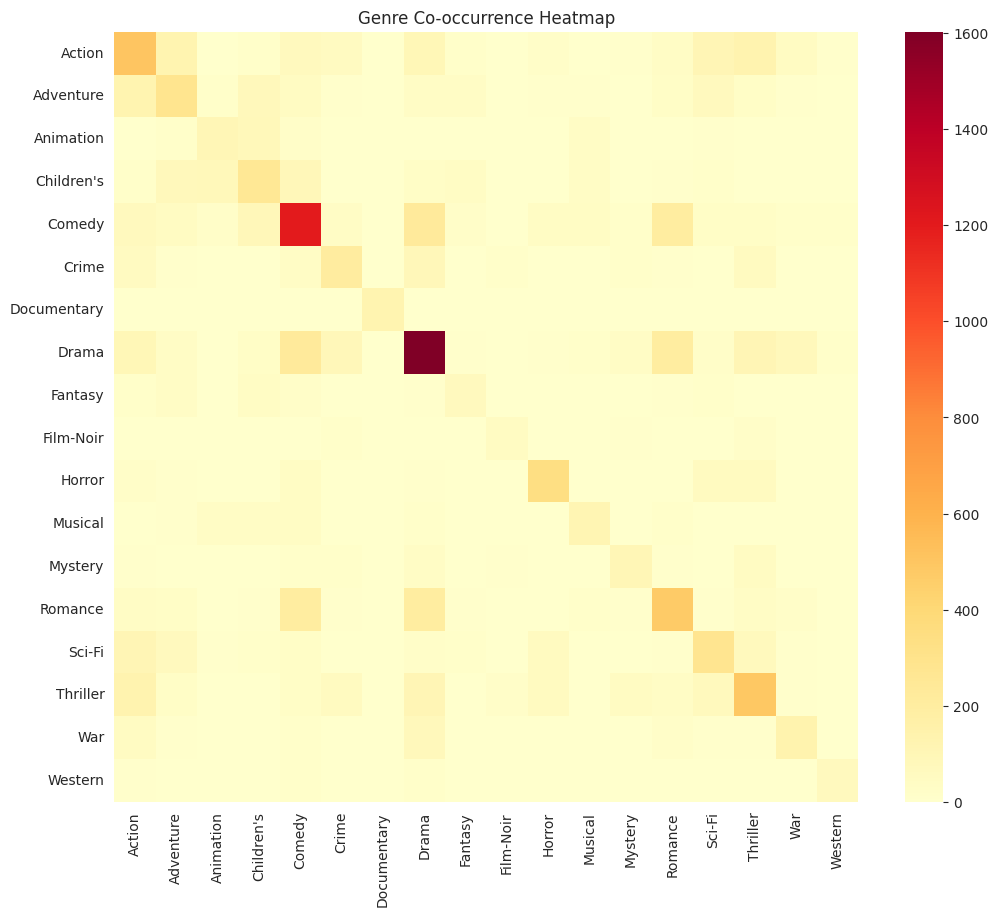

In [25]:
# 2. Genre Co-occurrence Matrix (Heatmap)
# Create a Multi-Hot Matrix manually for visualization
genre_list = sorted(genres_exploded['Genres'].unique())
co_occurrence = pd.DataFrame(0, index=genre_list, columns=genre_list)

for genres in movies['Genres'].str.split('|'):
    for g1 in genres:
        for g2 in genres:
            co_occurrence.loc[g1, g2] += 1

plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence, cmap='YlOrRd', annot=False)
plt.title('Genre Co-occurrence Heatmap')
plt.show()

In [26]:
# 3. TF-IDF Validation check
print("\n--- TF-IDF Validation ---")

# Prepare data
movies['genres_str'] = movies['Genres'].str.replace('|', ' ', regex=False)

# Fit TF-IDF
tfidf = TfidfVectorizer(token_pattern=r"(?u)\b[A-Za-z-]+\b")
tfidf_matrix = tfidf.fit_transform(movies['genres_str'])

print("Top 10 High-IDF Terms (Rarest Genres):")
indices = np.argsort(tfidf.idf_)[::-1]
features = np.array(tfidf.get_feature_names_out())
print(features[indices][:10])

# Function to get similar movies
def get_similar_movies(title, k=5):
    idx = movies[movies['Title'].str.contains(title, case=False)].index
    if len(idx) == 0:
        return f"Movie '{title}' not found."
    idx = idx[0]
    
    # Compute cosine similarity for this movie against all others
    sim_scores = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()
    
    # Get top k indices
    top_indices = sim_scores.argsort()[-(k+1):-1][::-1]
    
    input_movie = movies.iloc[idx]
    print(f"\nMovies similar to '{input_movie['Title']}' ({input_movie['Genres']}):")
    
    return movies.iloc[top_indices][['Title', 'Genres']]

# Dry Run
print(get_similar_movies("Toy Story"))
print(get_similar_movies("Star Wars"))


--- TF-IDF Validation ---
Top 10 High-IDF Terms (Rarest Genres):
['film-noir' 'fantasy' 'western' 'animation' 'mystery' 'musical'
 'documentary' 'war' 'crime' 'children']

Movies similar to 'Toy Story (1995)' (Animation|Children's|Comedy):
                                           Title                       Genres
2072                    American Tail, An (1986)  Animation|Children's|Comedy
2073  American Tail: Fievel Goes West, An (1991)  Animation|Children's|Comedy
2286                        Bug's Life, A (1998)  Animation|Children's|Comedy
2285                   Rugrats Movie, The (1998)  Animation|Children's|Comedy
0                               Toy Story (1995)  Animation|Children's|Comedy

Movies similar to 'Star Wars: Episode IV - A New Hope (1977)' (Action|Adventure|Fantasy|Sci-Fi):
                                           Title  \
2036                                 Tron (1982)   
257    Star Wars: Episode IV - A New Hope (1977)   
2899                         Time Ban

### 3.6 Strategy Feasibility Check

Our proposed hybrid strategy involves *"Retrieving the top 5 movies the user has rated 5 stars"* to find similar content. 
Let's verify what percentage of users actually HAVE at least 5 ratings of 5 stars. If this number is low, we might need to relax the condition (e.g., include 4 stars).

In [27]:
# Filter for 5-star ratings
high_ratings = ratings[ratings['Rating'] == 5]

# Count 5-star ratings per user
user_5star_counts = high_ratings.groupby('UserID').size()

# Calculate stats
total_users = ratings['UserID'].nunique()
users_with_enough_5stars = (user_5star_counts >= 5).sum()
percent_eligible = (users_with_enough_5stars / total_users) * 100

print(f"Total Users: {total_users}")
print(f"Users with at least 5 five-star ratings: {users_with_enough_5stars} ({percent_eligible:.2f}%)")

# Check with 4+ stars as backup
high_ratings_4plus = ratings[ratings['Rating'] >= 4]
user_4plus_counts = high_ratings_4plus.groupby('UserID').size()
users_with_enough_4plus = (user_4plus_counts >= 5).sum()
percent_eligible_4plus = (users_with_enough_4plus / total_users) * 100

print(f"Users with at least 5 four-plus-star ratings: {users_with_enough_4plus} ({percent_eligible_4plus:.2f}%)")

Total Users: 6040
Users with at least 5 five-star ratings: 5652 (93.58%)
Users with at least 5 four-plus-star ratings: 6034 (99.90%)


## 4. Conclusion

Key takeaways from the EDA:
- The rating distribution is skewed towards positive ratings (3 and 4).
- **Top Rated**: With a minimum of 100 votes, we identified the true audience favorites.
- **Genre Analysis**: The TF-IDF sanity check confirms that finding similar movies by genre works reasonably well.
- **Hybrid Viability**: Users generally have enough high-rated movies to support the Content-Based expansion strategy (confirmed by section 3.6).